# LST-NDVI correlation

**Data information:**    

* MODIS data
* temporal frequency: 8-day
* spatial frequency: 500m
* (xmin, ymin, xmax, ymax) = (20, 0, 42.56, 20)
    

**Importing modules**

In [3]:
from datetime import date, timedelta
from math import *
import os

from dateutil.relativedelta import relativedelta
import ipywidgets as widgets
from ipywidgets import fixed
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from progressbar import ProgressBar
import rasterio as rio
from rasterio.windows import Window
import re
import seaborn as sns
import time

**Functions**

date functions

In [4]:
def filename_to_gregorian(filename: str):
    '''Converts filename to date tuple'''

    # seeking for date pattern in the filename
    pattern = re.search(r'\d{4}j\d{3}', filename).group()

    # getting year and DOY
    year = int(pattern[0:4])
    day = int(pattern[5:8])
    
    # converting DOY to gregorian
    gregorian = date(year, 1, 1) + timedelta(day - 1)
    
    return gregorian

def gregorian_to_DOY(month: int, day:int):
    '''Converts gregorian date to DOY'''
    
    # we chose 2020 randomly because the year isn't taken into account
    DOY = (date(2020,month,day) - date(2020, 1, 1)).days + 1
    return DOY

Reading files functions

In [5]:
def raster_plot(raster_ndvi, raster_tda, raster_tna):
    
    fig, (ax1, ax2, ax3)  = plt.subplots(1,3,figsize=(20,10))
    
    with rio.open(raster_ndvi) as src:
        aoi = src.read(1)        
        aoi = unscaling(aoi, 'ndvi')
        im1 = ax1.imshow(aoi);
        fig.colorbar(im1, ax = ax1)
        im1.set_clim(0.1,0.9)
        ax1.set_title('NDVI')
        ax1.set_xticks(np.linspace(0, 2727, num=7))
        ax1.set_yticks(np.linspace(0, 2417, num=7))
        ax1.set_xticklabels([str(round(x,2)) for x in np.linspace(src.bounds.left, src.bounds.right, num=7)])
        ax1.set_yticklabels([str(round(x,2)) for x in np.linspace(src.bounds.top, src.bounds.bottom, num=7)])
        
        
    with rio.open(raster_tda) as src:
        aoi = src.read(1)        
        aoi = unscaling(aoi, 'tda')
        im2 = ax2.imshow(aoi);
        fig.colorbar(im2, ax = ax2)
        im2.set_clim(0,60)
        ax2.set_title('TDA')
        ax2.set_xticks(np.linspace(0, 2727, num=7))
        ax2.set_yticks(np.linspace(0, 2417, num=7))
        ax2.set_xticklabels([str(round(x,2)) for x in np.linspace(src.bounds.left, src.bounds.right, num=7)])
        ax2.set_yticklabels([str(round(x,2)) for x in np.linspace(src.bounds.top, src.bounds.bottom, num=7)])
        
        
    with rio.open(raster_tna) as src:
        aoi = src.read(1)        
        aoi = unscaling(aoi, 'tna')
        im3 = ax3.imshow(aoi);
        fig.colorbar(im3, ax = ax3)
        im3.set_clim(0,30)
        ax3.set_title('TNA')
        ax3.set_xticks(np.linspace(0, 2727, num=7))
        ax3.set_yticks(np.linspace(0, 2417, num=7))
        ax3.set_xticklabels([str(round(x,2)) for x in np.linspace(src.bounds.left, src.bounds.right, num=7)])
        ax3.set_yticklabels([str(round(x,2)) for x in np.linspace(src.bounds.top, src.bounds.bottom, num=7)])
        
def extract_ts(rasters: list, lat: float, lon: float, N: int, raster_type: str, loc: str):
    '''Extracts time series from rasters list at location (lat, lon)
    loc = 'coordinate' or 'pixel' '''
    
    ts = []
    
    for rt in rasters:
        
        with rio.open(rt) as src:
            
            #selecting NxN pixel at lat lon coordinates
            
            if (loc == 'coordinate'):
                (y,x) = rio.transform.rowcol(src.transform, lat, lon)
            else:
                (x,y) = (lat,lon)
           
            subset = src.read(1, window=Window(x-((N-1)/2),y-((N-1)/2),N,N)) 
            
            #unscaling the values
            subset = unscaling(subset, raster_type)
            
            #mean over lat and lon
            m = np.mean(subset)
        
            #adding to ts
            ts.append(m)
    
    return ts


def unscaling(subset, raster_type: str):
    
    if (raster_type=="ndvi"):
        subset = subset/10000
    else:
        subset =subset * 0.02 - 273.15

    return subset

Selecting zone

In [6]:
def select_point(raster_tda):
    
    plt.figure(figsize=(15,6))
    
    with rio.open(raster_tda) as src:
        aoi = src.read(1)        
        aoi = unscaling(aoi, 'tda')
        im = plt.imshow(aoi);
        im.set_clim(0,60)
        plt.title('Select center point of the zone')
        latlon = plt.ginput(1) 
        
        return latlon       
    
def red_rectangle(raster_tda, x: float , y: float, N: int):
    
    fig, (ax)  = plt.subplots(1,figsize=(20,10))
    
    with rio.open(raster_tda) as src:
        aoi = src.read(1)        
        aoi = unscaling(aoi, 'tda')
        im = ax.imshow(aoi);
        im.set_clim(0,60)
        ax.set_title('Selected Zone')
        ax.set_xticks(np.linspace(0, 2727, num=7))
        ax.set_yticks(np.linspace(0, 2417, num=7))
        ax.set_xticklabels([str(round(x,2)) for x in np.linspace(src.bounds.left, src.bounds.right, num=7)])
        ax.set_yticklabels([str(round(x,2)) for x in np.linspace(src.bounds.top, src.bounds.bottom, num=7)])

        rect = patches.Rectangle((int(x - N/2),int(y - N/2)),N,N,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

LTA functions 

In [7]:
def anomaly(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta =  lta_dict(index, ts)    
    anom = []


    for i,x in enumerate(index):

        key = '{}-{}'.format(x.month, x.day)
        anom.append((ts[i] - lta[key])/np.std(ts))
        
    return anom

def lta_dict(index: pd.DatetimeIndex, ts: pd.Series):
    
    lta_begin = date(2002,7,1)
    lta_end = date(2018,7,1)

    mondays = {'{}-{}'.format(x.month, x.day) for x in index}

    # initialize the dicts
    lta_dict = {}

    for md in mondays:

        lta = 0 
        nb = 0

        month, day = md.split('-')
        month, day = (int(month), int(day))

        # converting gregorian to DOY
        DOY = gregorian_to_DOY(month = month, day = day)

        for ix, date_sel in enumerate(index):

            # only select the dates in LTA period
            if date_sel < lta_begin or date_sel > lta_end:
                continue

            DOYsel = gregorian_to_DOY(month = date_sel.month, day = date_sel.day)

            if DOYsel == DOY:
                lta += ts[ix]
                nb += 1


        # add to LTA dict
        lta_dict[md] = lta/nb
        
    return lta_dict

Plot functions 

In [40]:
def plot1(df: pd.DataFrame, year_range:tuple):
    
    begin = date(year_range[0],1,1)
    end = date(year_range[1],1,1)
    
    #CROPPING TO RIGHT SIZE
    df = df[(df.index > np.datetime64(begin))]
    df = df[(df.index < np.datetime64(end))]
    
    
    #NORMAL
    ax = df.plot(y = ["TDA","TNA","NDVI"],
                 secondary_y = ["NDVI"],
                 figsize=(20,5), 
                 color=('darkcyan','yellowgreen','salmon'),
                 rot=0, 
                 style = ['-','-','-'], 
                 alpha = 0.6)

    ax.set_xlabel("")
    ax.set_title("Smoothed TDA, TNA and NDVI",fontsize=20);
    
    fig = ax.get_figure()
    fig.savefig("normal.png")
    
    #STANDARDIZED
    ax = df.plot(y = ["ZTDA","ZTNA","ZNDVI"],
                 figsize=(20,5), 
                 color=('darkcyan', 'yellowgreen', 'salmon'),
                 rot=0, 
                 style = ['-','-','-'], 
                 alpha = 0.6)

    ax.set_xlabel("")
    ax.set_title("Standardized TDA, TNA and NDVI",fontsize=20);
    
    fig = ax.get_figure()
    fig.savefig("standard.png")
    
    
    #ANOMALIE
    ax = df.plot(y = ["TDA_anom","TNA_anom","NDVI_anom"],
                 figsize=(20,5), 
                 color=('darkcyan','yellowgreen','salmon'),
                 rot=0, 
                 style = ['-','-','-'], 
                 alpha = 0.6)

    ax.plot(df.index,np.ones(len(df.index))*0, color = 'k', alpha=0.6)
    ax.set_xlabel("")
    ax.set_title("Standardized anomalies TDA, TNA and NDVI",fontsize=20);
    
    fig = ax.get_figure()
    fig.savefig("anom.png")

    
def plot2(df: pd.DataFrame, year_range:tuple):
    
    begin = date(year_range[0],1,1)
    end = date(year_range[1],1,1)
    
    df = df.rename(columns={"dif": "TDA - TNA"})
    
    #CROPPING TO RIGHT SIZE
    df = df[(df.index > np.datetime64(begin))]
    df = df[(df.index < np.datetime64(end))]
    
    
    #NORMAL
    ax = df.plot(y = ["TDA - TNA","NDVI"],
                 secondary_y = ["NDVI"],
                 figsize=(20,5), 
                 color=('cornflowerblue','salmon'),
                 rot=0, 
                 style = ['-','-','-'], 
                 alpha = 0.6)

    ax.set_xlabel("")
    ax.set_title("Smoothed (TDA - TNA) and NDVI",fontsize=20);
    
    #STANDARDIZED
    ax = df.plot(y = ["Zdif","ZNDVI"],
                 figsize=(20,5), 
                 color=('cornflowerblue', 'salmon'),
                 rot=0, 
                 style = ['-','-','-'], 
                 alpha = 0.6)

    ax.legend(['standardized TDA - TNA ', 'standardized NDVI'])
    ax.set_xlabel("")
    ax.set_title("Standardized (TDA - TNA) and NDVI",fontsize=20);
    
    
    #ANOMALIE
    ax = df.plot(y = ["dif_anom","NDVI_anom"],
                 figsize=(20,5), 
                 color=('cornflowerblue','salmon'),
                 rot=0, 
                 style = ['-','-','-'], 
                 alpha = 0.6)

    ax.legend(['TDA - TNA anom', 'NDVI anom'])
    ax.plot(df.index,np.ones(len(df.index))*0, color = 'k', alpha=0.6)
    ax.set_xlabel("")
    ax.set_title("Standardized anomalies (TDA - TNA) and NDVI",fontsize=20);  
    
    

Lag functions

In [9]:
def pearson_corr(df: pd.DataFrame):
  
    fig, ax  = plt.subplots(2,3,figsize=(20,10))
    
    #CROSS CORR TS
    
    correlation = []
    for lag in np.arange(-5,30,1):
        correlation.append(df['TDA'].corr(df['NDVI'].shift(lag)))
  
    ax[0,0].plot(np.arange(-5,30,1), correlation)
    ax[0,0].set_title('TDA and NDVI cross-correlation')
    ax[0,0].set_xlabel("lag");
    ax[0,0].set_ylabel("Pearson correlation");
    ax[0,0].legend("");
    
    correlation = []
    for lag in np.arange(-5,30,1):
        correlation.append(df['TNA'].corr(df['NDVI'].shift(lag)))
 
    ax[0,1].plot(np.arange(-5,30,1), correlation)
    ax[0,1].set_title('TNA and NDVI cross-correlation')
    ax[0,1].set_xlabel("lag");
    ax[0,1].set_ylabel("Pearson correlation");
    ax[0,1].legend("");
    
    correlation = []
    for lag in np.arange(-5,30,1):
        correlation.append(df['dif'].corr(df['NDVI'].shift(lag)))
  
    ax[0,2].plot(np.arange(-5,30,1), correlation)
    ax[0,2].set_title('(TDA - TNA) and NDVI cross-correlation')
    ax[0,2].set_xlabel("lag");
    ax[0,2].set_ylabel("Pearson correlation");
    ax[0,2].legend("");
    
    
    #CROSS CORR ANOMALIE
    
    correlation = []
    for lag in np.arange(-5,30,1):
        correlation.append(df['TDA_anom'].corr(df['NDVI_anom'].shift(lag)))
  
    ax[1,0].plot(np.arange(-5,30,1), correlation)
    ax[1,0].set_title('TDA and NDVI anomalies cross-correlation')
    ax[1,0].set_xlabel("lag");
    ax[1,0].set_ylabel("Pearson correlation");
    ax[1,0].legend("");
    
    correlation = []
    for lag in np.arange(-5,30,1):
        correlation.append(df['TNA_anom'].corr(df['NDVI_anom'].shift(lag)))
 
    ax[1,1].plot(np.arange(-5,30,1), correlation)
    ax[1,1].set_title('TNA and NDVI anomalies cross-correlation')
    ax[1,1].set_xlabel("lag");
    ax[1,1].set_ylabel("Pearson correlation");
    ax[1,1].legend("");
    
    correlation = []
    for lag in np.arange(-5,30,1):
        correlation.append(df['dif_anom'].corr(df['NDVI_anom'].shift(lag)))
  
    ax[1,2].plot(np.arange(-5,30,1), correlation)
    ax[1,2].set_title('(TDA - TNA) and NDVI anomalies cross-correlation')
    ax[1,2].set_xlabel("lag");
    ax[1,2].set_ylabel("Pearson correlation");
    ax[1,2].legend("");

### Downloading the Data

In [10]:
rasters_ndvi = ['NDVI/'+ x for x in os.listdir('NDVI')]
rasters_tda = ['TDA/'+ x for x in os.listdir('TDA')]
rasters_tna = ['TNA/'+ x for x in os.listdir('TNA')]

Overview 

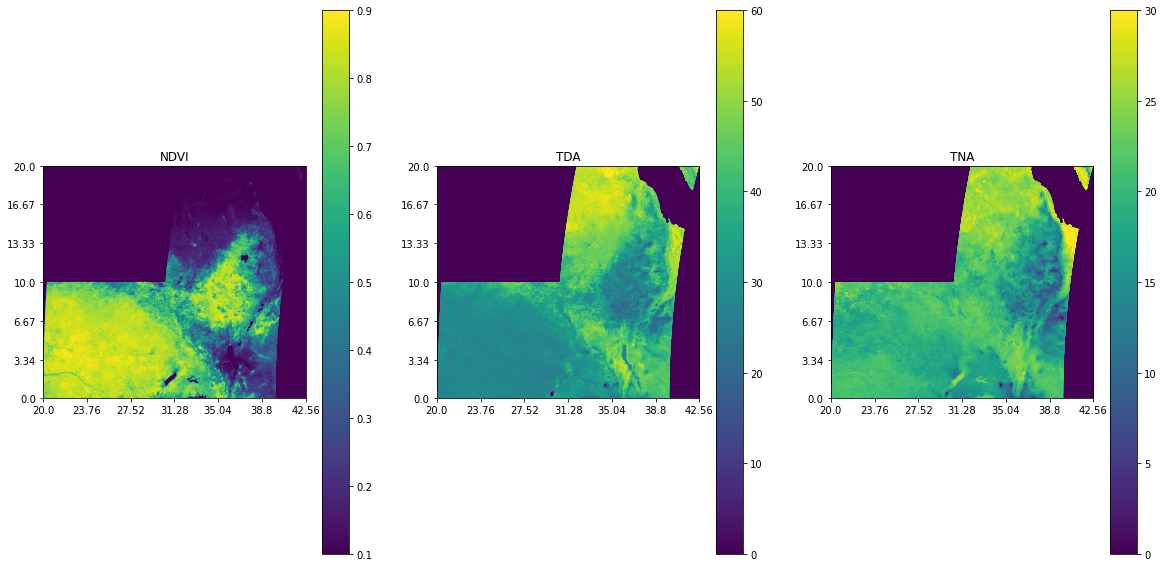

In [11]:
raster_plot(rasters_ndvi[0], rasters_tda[0], rasters_tna[0])

### Time series Analysis

In [12]:
N = 5

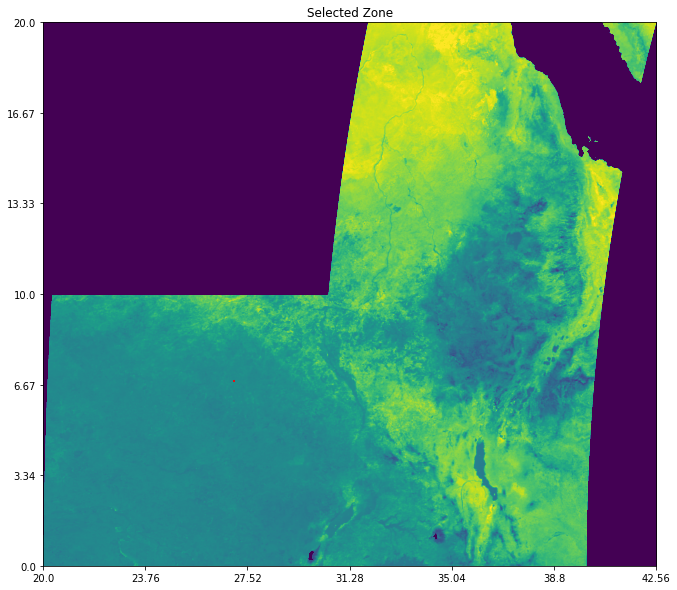

In [13]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

latlon = select_point(rasters_tda[0])

matplotlib.use("Agg")

lat = latlon[0][0]
lon = latlon[0][1]
red_rectangle(rasters_tda[0], lat, lon, N)

In [14]:
# OR ENTER VALUES (PIXELS)
#lat = 636
#lon = 2358

In [15]:
#extracting time series
ts_ndvi = extract_ts(rasters_ndvi, lat = lat, lon = lon, N = N, raster_type= 'ndvi', loc = 'pixel')
ts_tda = extract_ts(rasters_tda, lat = lat, lon = lon, N = N, raster_type= 'tda', loc = 'pixel')
ts_tna = extract_ts(rasters_tna, lat = lat, lon = lon, N = N, raster_type= 'tna', loc = 'pixel')
ts_dif = np.array(ts_tda) - np.array(ts_tna)

#creating date index
dates = pd.DatetimeIndex([filename_to_gregorian(x) for x in rasters_ndvi])

# creating DataFrame
df = pd.DataFrame({'Dates': dates, 'NDVI': ts_ndvi, 'TDA': ts_tda, 'TNA': ts_tna, 'dif': ts_dif})
df = df.set_index('Dates')

#standardized values
df["ZTDA"] = (df['TDA'] - np.mean(df['TDA']))/np.std(df['TDA']) 
df["ZTNA"] = (df['TNA'] - np.mean(df['TNA']))/np.std(df['TNA'])
df["ZNDVI"] = (df['NDVI'] - np.mean(df['NDVI']))/np.std(df['NDVI'])
df["Zdif"] = (df['dif'] - np.mean(df['dif']))/np.std(df['dif'])

#standardized anomalies
df["TDA_anom"] = anomaly(df.index, df.TDA)
df["TNA_anom"] = anomaly(df.index, df.TNA)
df["NDVI_anom"] = anomaly(df.index, df.NDVI)
df["dif_anom"] = anomaly(df.index, df.dif)

**Plots**

In [22]:
y = widgets.IntRangeSlider(
    value=[2010,2020],
    min=2002,
    max=2021,
    step=1,
    description='Year Range:')
y

IntRangeSlider(value=(2010, 2020), description='Year Range:', max=2021, min=2002)

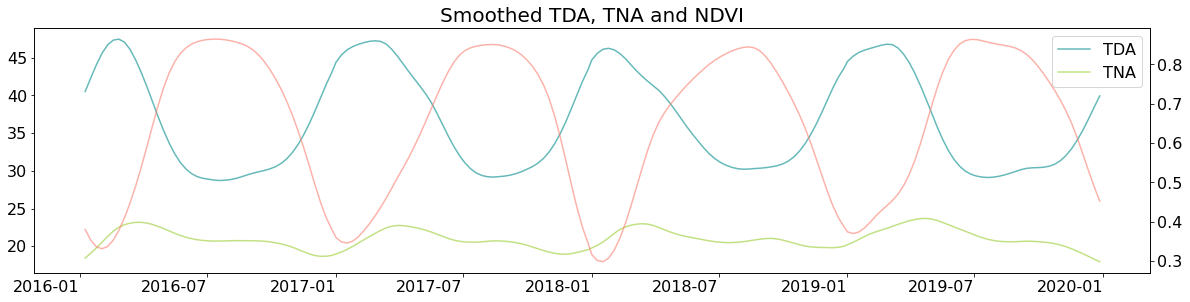

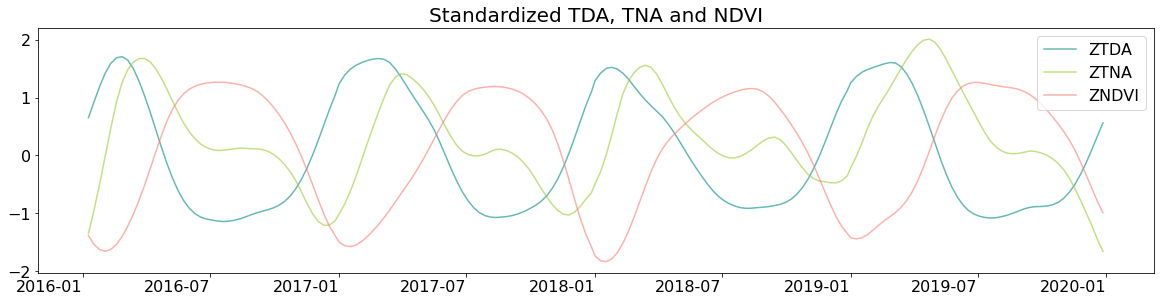

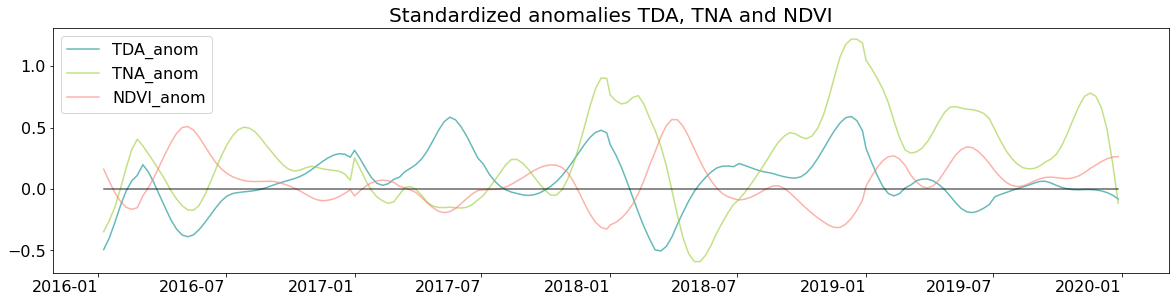

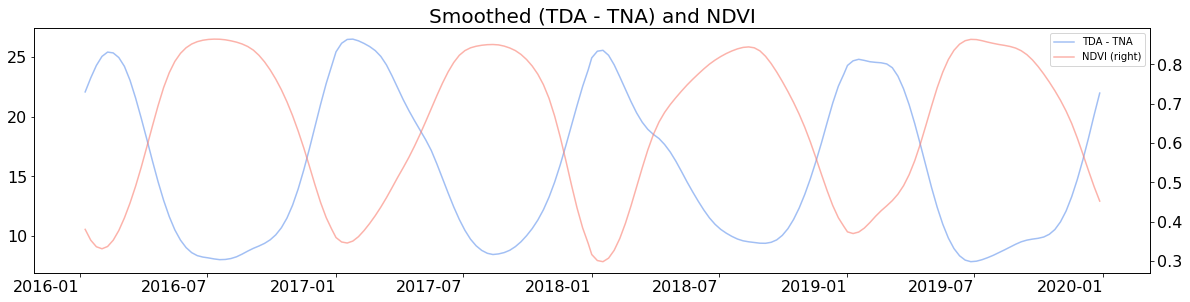

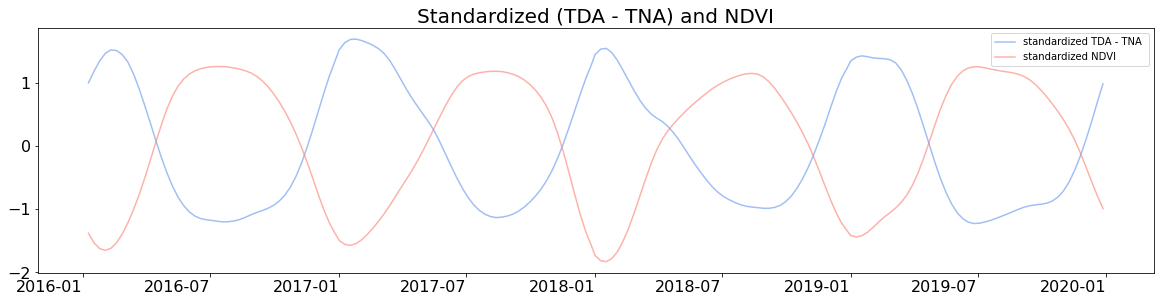

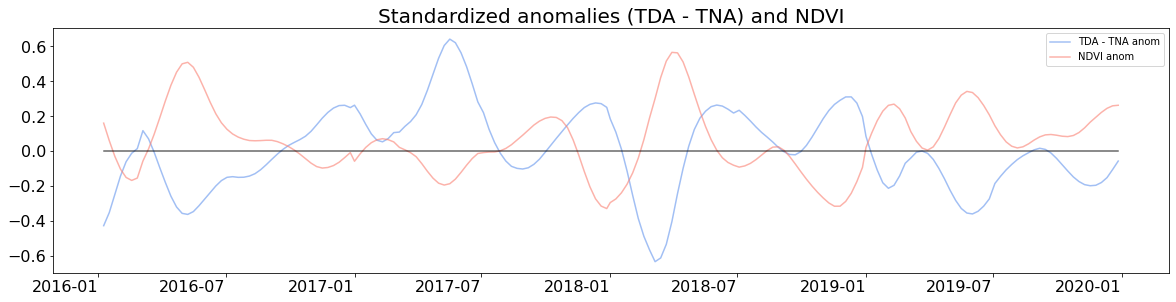

In [41]:
plot1(df, y.value)
plot2(df, y.value)

**Lag Analysis**

Lag for all of the data (not just the year range selected previously)

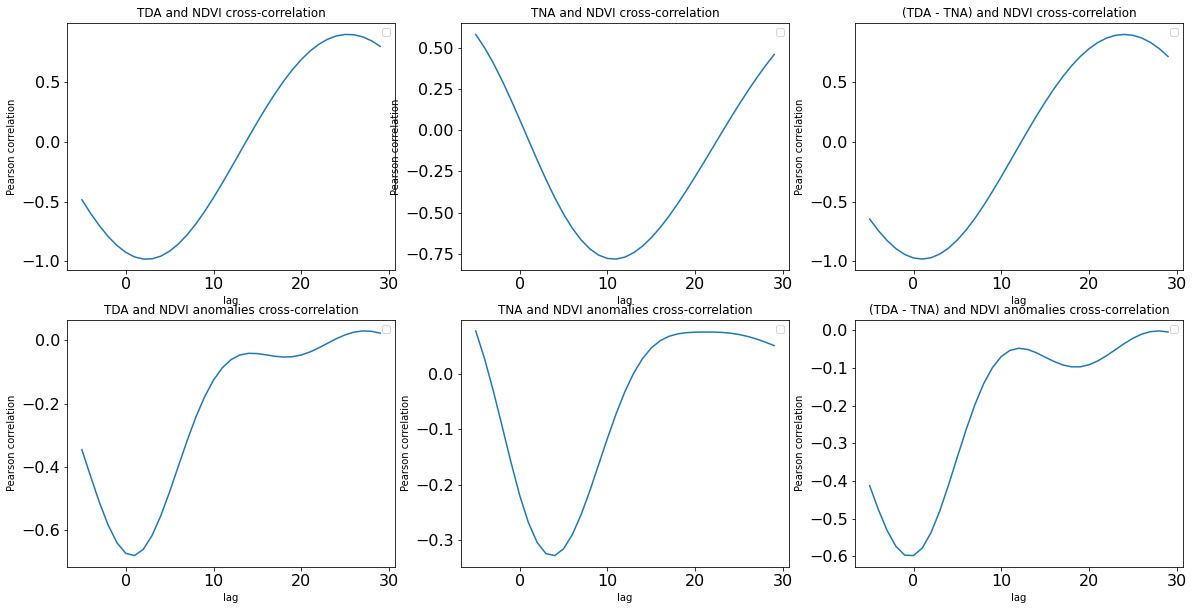

In [42]:
pearson_corr(df)